In [1]:
import os
from IPython.display import IFrame, HTML
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pysal as ps
from shapely.geometry import Point, Polygon

C:\Anaconda3\envs\gds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [6]:
os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'arcgis.ipynb',
 'choropleth-map-example.png',
 'data',
 'geo_doodle.py',
 'my_functions_geo.py',
 'new_workflow.ipynb',
 'parking_Toronto.ipynb',
 'README.md',
 'Teranet_GTHA_DA_investigating_pins.ipynb',
 'Teranet_GTHA_DA_spatial_join.ipynb',
 'Teranet_GTHA_DA_workflow.ipynb',
 '__pycache__']

In [3]:
from my_functions_geo import column_kde
from my_functions_geo import series_choropleth

In [3]:
api_url = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_income_gdf = gpd.read_file(api_url)
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!


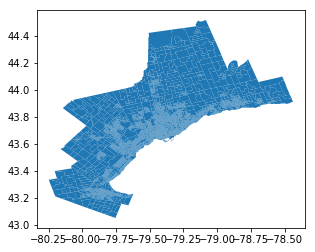

In [4]:
da_income_gdf.plot();

In [7]:
# verify the path to Teranet dataset
save_file_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'
# read Teranet dataset with a column containing Dissimination Areas id
teranet_da_df = pd.read_csv(save_file_path)
# drop unnecessary columns
teranet_da_df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)

In [8]:
# covert 'registration_date' to datetime data format
teranet_da_df['registration_date'] = pd.to_datetime(teranet_da_df['registration_date'])
print("Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!")

Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!


In [9]:
# group Teranet dataset by Dissimination Area id
da_groups = teranet_da_df.groupby(by='da_id')

In [13]:
# Make an aggregate (count of all records) from Teranet data
teranet_da_agg_count = pd.DataFrame(da_groups['registration_date'].count())
print("Done!")

Done!


In [14]:
# key to be used for the JOIN in Teranet DA groups -- 'index'
teranet_da_agg_count.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=9168)

In [15]:
# Key to be used for the JOIN in gdf with Dissimination Areas -- column 'OBJECTID'
da_income_gdf[['OBJECTID']].sort_values(by='OBJECTID')

,OBJECTID
3000,1
3001,2
3002,3
3003,4
3004,5
3005,6
3006,7
3007,8
3008,9
3009,10


In [16]:
# perform the JOIN of Teranet aggregate with DA gdf
teranet_column_name = 'registration_date'
new_column_name = 'teranet_sales_count'
# save projection information from GeoDataFrame with DAs
crs = da_income_gdf.crs
# JOIN Teranet aggregate to GeoDataFrame with DAs (produces a DataFrame)
teranet_da_gdf = pd.merge(teranet_da_agg_count,
                          da_income_gdf,
                          left_on=teranet_da_agg_count.index,
                          right_on=da_income_gdf['OBJECTID'])
# rename the column containing aggregate Teranet information
teranet_da_gdf.rename(columns={teranet_column_name:new_column_name}, inplace=True)
# convert DataFrame to GeoDataFrame
teranet_da_gdf = gpd.GeoDataFrame(teranet_da_gdf, 
                                  geometry=teranet_da_gdf['geometry'])
# add projection information to the new GeoDataFrame
teranet_da_gdf.crs = crs
print("Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!")

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!


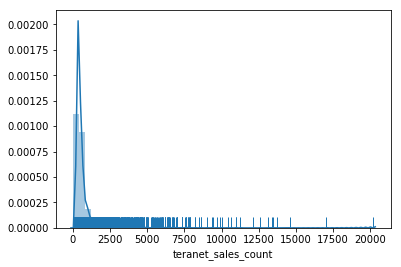

In [19]:
sns.distplot(teranet_da_gdf['teranet_sales_count'], rug=True)

In [20]:
teranet_da_gdf['teranet_sales_count'].sum()

6062853

In [21]:
w_queen = ps.lib.weights.Queen.from_dataframe(teranet_da_gdf)
w_queen.remap_ids(teranet_da_gdf.index)
w_queen

C:\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\contiguity.py:184: UserWarning: There is one disconnected observation (no neighbors).
Island id: 1298
  W.__init__(self, neighbors, ids=ids, **kw)


In [24]:
w_queen[0]

{1072: 1.0, 1: 1.0, 52: 1.0, 53: 1.0, 279: 1.0, 313: 1.0, 1071: 1.0}

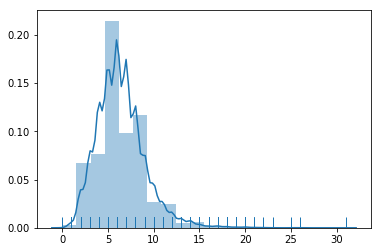

In [27]:
queen_card = pd.Series(w_queen.cardinalities)
sns.distplot(queen_card, rug=True, bins=20)

In [28]:
# Number of observations
w_queen.n

9168

In [29]:
# Average number of neighbors
w_queen.mean_neighbors

6.422993019197207

In [30]:
# Min number of neighbors
w_queen.min_neighbors

0

In [31]:
# Max number of neighbors
w_queen.max_neighbors

31

In [32]:
# Islands (observations disconnected)
w_queen.islands

[1298]

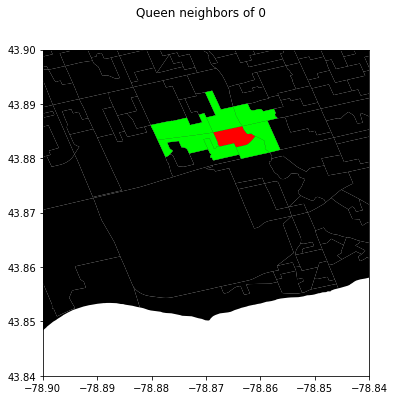

In [46]:
focus_da_id = 0
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
teranet_da_gdf.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = teranet_da_gdf.loc[[focus_da_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = teranet_da_gdf.loc[list(w_queen[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of {0}".format(focus_da_id))
# Style and display on screen
ax.set_ylim(43.84, 43.9)
ax.set_xlim(-78.9, -78.84)
# ax.set_ylim(focus.centroid.y - 0.5, focus.centroid.y + 0.5)
# ax.set_xlim(focus.centroid.x - 0.5, focus.centroid.x + 0.5)
plt.show()

In [52]:
data = teranet_da_gdf.to_crs(epsg=27700)
data.crs

{'init': 'epsg:27700', 'no_defs': True}

In [54]:
w_dist1kmB = ps.lib.weights.DistanceBand.from_dataframe(data, 
                                                        1000, 
                                                        binary=True)
w_dist1kmB

C:\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 688 disconnected observations 
  Island ids: 38, 39, 61, 84, 85, 96, 101, 103, 106, 116, 117, 144, 145, 149, 154, 155, 157, 161, 162, 163, 164, 165, 166, 167, 168, 176, 177, 190, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 252, 257, 265, 269, 314, 315, 356, 413, 422, 438, 466, 470, 472, 498, 507, 524, 530, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 712, 718, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1073, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1235, 1237, 1238, 1244, 1245

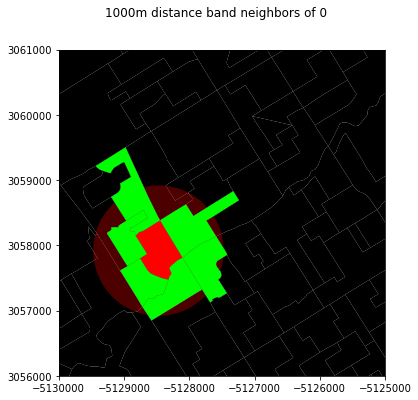

In [59]:
focus_da_id = 0
dist=1000
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
data.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = data.loc[[focus_da_id]]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
focus.centroid.buffer(dist).plot(facecolor='red', alpha=0.3, ax=ax)
# Plot neighbors
neis = data.loc[list(w_dist1kmB[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("{0}m distance band neighbors of {1}"
           .format(dist, focus_da_id))
# Style and display on screen
y_lim = 3056000
x_lim = -5130000
step = 5000
ax.set_ylim(y_lim, y_lim + step)
ax.set_xlim(x_lim, x_lim + step)
plt.show()

In [61]:
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_da_df['x'], teranet_da_df['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
point_data = gpd.GeoDataFrame(teranet_da_df, geometry=geometry)
print("Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!")

Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!


In [67]:
%%time
# add CRS for WGS84 (lat-long) to GeoDataFrame 'sales_data_geo'
point_data.crs = {'proj': 'latlong', 
                  'ellps': 'WGS84', 
                  'datum': 'WGS84', 
                  'no_defs': True}
points_data = point_data.to_crs(epsg=27700)
point_data.crs

Wall time: 6min 2s


In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
data.plot(ax=ax, facecolor='k', linewidth=0.1)
# plot point data
point_data.head(1000).plot(ax=ax)
# Title
f.suptitle("Sample of Teranet sales with DAs")
# Style and display on screen
y_lim = 3056000
x_lim = -5130000
step = 5000
# ax.set_ylim(y_lim, y_lim + step)
# ax.set_xlim(x_lim, x_lim + step)
plt.show()

In [66]:
%%time
w_point_dist1kmC = ps.lib.weights.DistanceBand.from_dataframe(point_data, 
                                                        1000, 
                                                        binary=False)
w_point_dist1kmC


ValueError: Could not make array from data